In [1]:
import pygplates
from gprm import PointDistributionOnSphere
from gprm.datasets import Reconstructions
import pygmt
import numpy as np
import geopandas as gpd

%load_ext autoreload
%autoreload 2


In [2]:
M2019 = Reconstructions.fetch_Muller2019()


In [3]:
topological_model = pygplates.TopologicalModel(
            M2019.dynamic_polygons,
            M2019.rotation_model,
            # Enable strain rate clamping to better control crustal stretching factors...
            default_resolve_topology_parameters=pygplates.ResolveTopologyParameters(enable_strain_rate_clamping=True))


In [4]:
features = pygplates.FeatureCollection('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

gdf = gpd.read_file('/Users/simon/GIT/pygplates-paleo/strat/tibet_geochem.geojson')

#for feature in features:
#    print(feature.get_shapefile_attributes())
#    break


In [5]:
def deform_geometries(gdf, topological_model, reconstruction_time, 
                      initial_time=0, final_time=None,
                      deactivate_points_that_fall_outside_a_network = True):
    
    # Given a geodataframe, will reconstruct using a topological model to a given reconstruction time
    
    # TODO adapt for polylines and polygons
    
    # Do this to detect cases with a mixture of types? (and tell user this isn't supported?)
    # gdf.geom_type.unique()
    
    if not final_time:
        final_time = reconstruction_time
    
    #reconstructed_features_list = []
    
    # Preprocessing:
    gdf = gdf[gdf.geometry.is_valid]   # remove invalid geometries
    gdf = gdf[(gdf.FROMAGE>=reconstruction_time) & (gdf.TOAGE<=reconstruction_time)]   # select points valid at reconstruction time
    gdf = gdf.explode()   # multipart to singlepart
    gdf.reset_index(inplace=True)   # reset index
    
    
    # Should work for points, but for polygon/polyline need to iterate over each feature 
    geometry_points = [(lat,lon) for lat,lon in zip(gdf.geometry.y,gdf.geometry.x)]
    
    time_spans = topological_model.reconstruct_geometry(
                    geometry_points,
                    initial_time=initial_time,
                    oldest_time=final_time,
                    youngest_time=initial_time,
                    # All our points are on continental crust so we keep them active through time (ie, never deactivate them)...
                    deactivate_points = pygplates.ReconstructedGeometryTimeSpan.DefaultDeactivatePoints(
                        deactivate_points_that_fall_outside_a_network = deactivate_points_that_fall_outside_a_network))

    reconstructed_points = time_spans.get_geometry_points(reconstruction_time, return_inactive_points=True)
    
    #print(reconstructed_points)
    # TODO for cases where this could lead to an array of inconsistent length - maybe should allow points to be 'None'??
    #pts = list(zip(*[reconstructed_point.to_lat_lon() for reconstructed_point in reconstructed_points]))
    valid_index = [reconstructed_point is not None for reconstructed_point in reconstructed_points]
    #print(valid_index)
    pts = list(zip(*[reconstructed_point.to_lat_lon() for reconstructed_point in reconstructed_points if reconstructed_point is not None]))

    reconstructed_gdf = gdf.iloc[valid_index]
    reconstructed_gdf = reconstructed_gdf.set_geometry(gpd.points_from_xy(pts[1], pts[0]))
       
    return reconstructed_gdf
    


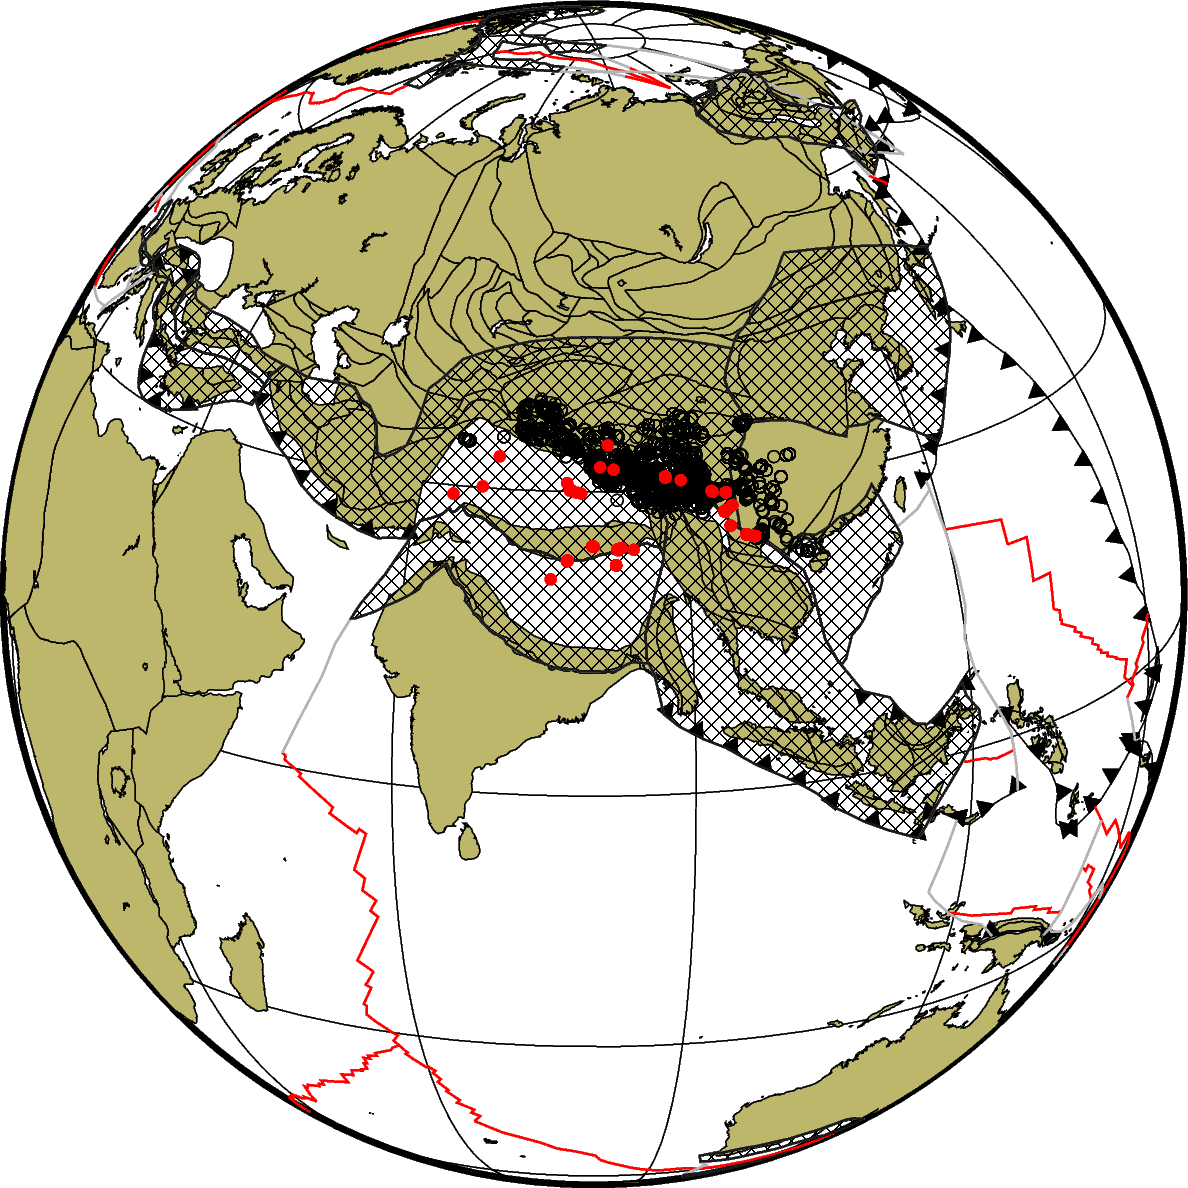

In [6]:
reconstruction_time = 35.

result = deform_geometries(gdf, topological_model, reconstruction_time, deactivate_points_that_fall_outside_a_network=None)

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)
reconstructed_continents = M2019.polygon_snapshot('coastlines', reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G80/20/10c', frame='afg')
#fig.coast(land='gray')
reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)
reconstructed_plates.plot_deformation_zones(fig)

fig.plot(x=gdf.geometry.x, y=gdf.geometry.y, style='c0.1c')
fig.plot(x=result.geometry.x, y=result.geometry.y, style='c0.1c', color='red')

fig.show(width=800)


In [7]:
result


,level_0,level_1,Data source,sample,Age,Age error,Lat,Long,87Sr/86Sr(i),εNd(t),...,Pb,Th,U,Sr/Y,La/Yb(n),Mg#,A/CNK,FROMAGE,TOAGE,geometry
0,207,0,"Chapman et al., 2018",15-19,36.10,1.20,38.483883,73.682450,0.706178,-2.732929,...,5.85,1.93,0.33,175.544542,32.043233,34.70,0.988544,38.10,34.10,POINT (69.06836 33.20992)
1,380,0,"Chen, B., et al., 2017",L13JP-20,35.01,0.31,22.757833,103.262150,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.01,33.01,POINT (97.51046 24.81635)
2,381,0,"Chen, B., et al., 2017",L13JP-21,35.00,NaN,22.757833,103.262150,0.707296,-5.100000,...,18.90,19.00,2.48,93.515152,35.708103,30.97,0.883646,37.00,33.00,POINT (97.51046 24.81635)
3,382,0,"Chen, B., et al., 2017",L13JP-22,35.00,NaN,22.757833,103.262150,0.707299,-5.200000,...,20.20,8.80,2.26,118.283582,19.556323,28.39,0.916071,37.00,33.00,POINT (97.51046 24.81635)
4,383,0,"Chen, B., et al., 2017",L13JP-23,35.00,NaN,22.757833,103.262150,NaN,NaN,...,19.60,8.20,2.05,111.142857,14.453721,28.22,0.921716,37.00,33.00,POINT (97.51046 24.81635)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,5017,0,"Yang, Z., et al., 2016",JR-11,36.30,NaN,29.636700,88.871667,NaN,NaN,...,NaN,42.10,3.19,34.000000,60.654008,24.00,1.040255,38.30,34.30,POINT (79.87174 24.65692)
131,5023,0,"Yang, Z., et al., 2016",JR11-13,36.30,NaN,29.636700,88.871667,NaN,NaN,...,NaN,7.00,2.06,108.500000,26.678941,50.00,0.937660,38.30,34.30,POINT (79.87174 24.65692)
132,5027,0,"Yang, Z., et al., 2016",JR11-18,36.30,NaN,29.636700,88.871667,NaN,NaN,...,NaN,45.60,3.55,14.500000,61.846871,19.00,1.025760,38.30,34.30,POINT (79.87174 24.65692)
133,5028,0,"Yang, Z., et al., 2016",JR11-20,36.30,NaN,29.636700,88.871667,NaN,NaN,...,NaN,50.20,4.07,14.000000,56.893460,19.00,1.026952,38.30,34.30,POINT (79.87174 24.65692)
